In [7]:
from matplotlib import animation
import sys
sys.path.append('/home/blist/diffpiso/PhiFlow')
sys.path.append('/home/blist/diffpiso')
sys.path.append('/home/blist/piso')
from diffpiso import *
from diffpiso.evaluation_helpers import EK_spectrum_2D
from kolmogorov_flow.networks import *
from kolmogorov_flow.evaluation_functions import *
import pickle
from datetime import datetime
from helpers import *

In [9]:
# ERROR METRIC CALCULATIONS
base_path = '/home/blist/datadrive/tests/'
frame_count = 251
evaluation_interval = 1
initial_frames = [[base_path + '/simulations/kolmogorovFlow_128-128_Re1000_wave6_dt0.005_000001/', [12700, 15800, 17000, 23800, 31000, 40200]],
                  [base_path + '/simulations/kolmogorovFlow_128-128_Re600_wave6_dt0.005_000000/',  np.array([180, 800, 1200, 2000, 2800, 3800])*4+10000]]
ReNbrs = [1000, 600]
dataset_wavenumber = 6
dataset_timestep = 0.005
dataset_resolution = [128,128]
resolution_factor = 4
resolution = [r//resolution_factor for r in dataset_resolution]
frame_increment = 4

In [10]:
# CORRECTION FULL LR_SCHEDULE TESTS
models = ['path_to_model_1', 'path_to_model_2']

# model groups: describes statistically equivalent setups, samples from groups are averaged  
# enter the index ranges of the models with the same group
model_groups = [0, 8, 16, ...]

# block groups: lists collect indices of model groups which share a block in the plot (e.g same network size of groups 0,4,8)
block_groups = [[0,4,8],[1,5,9], ...]
x_blocks = ['32k','0.1M', '0.5M','1M',]

In [16]:
# AUTOMATED MODEL LABELLING
resnet_features, feature_selector = get_features(models)

conv_skips = True
legend_colors = [ 'darkorchid', 'orchid', 'mediumblue' , 'cornflowerblue', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# legend selector: index for legends for each model group
legends, legend_selector = get_legend_selector(models, model_groups)
color_selector = get_color_selector(models, model_groups)

assert max([max(bg) for bg in block_groups]) == (len(model_groups)-2)
assert len(block_groups) == len(x_blocks)

domain = Domain(resolution, box=box[0:2 * np.pi, 0:2 * np.pi], boundaries=((PERIODIC, PERIODIC), (PERIODIC, PERIODIC)))
trajectories, reference_frames = load_trajectories(models, frame_count, evaluation_interval, ReNbrs)
mean_squared_error = [np.average((t[ ...] - reference_frames)[..., :2] ** 2, axis=(0, 1, 2, 3, 4, 5)) for t in trajectories]
average_mse, std_mse, nan_idx, grouped_mse = calculate_mse_stats(mean_squared_error, model_groups)
mse_dict = {'one-mean': average_mse[0:4], 'one-std': std_mse[0:4],
            'nog-mean': average_mse[4:8], 'nog-std': std_mse[4:8],
            'wgr-mean': average_mse[8:12], 'wgr-std': std_mse[8:12],}

/home/blist/datadrive/tests//2023_08_07/oneStepCurriculum/supervised_nFeat32369_1step_DS6000_000008/kolm_corr_sup_32-32_wave6_step1_inc4_rand53_lr1e-06_b1_servus03_000000/model_epoch_004.ckpt
/home/blist/datadrive/tests//2023_08_07/oneStepCurriculum/supervised_nFeat115803_1step_DS6000_000008/kolm_corr_sup_32-32_wave6_step1_inc4_rand53_lr1e-06_b1_servus03_000000/model_epoch_004.ckpt
/home/blist/datadrive/tests//2023_08_07/oneStepCurriculum/supervised_nFeat461235_1step_DS6000_000009/kolm_corr_sup_32-32_wave6_step1_inc4_rand53_lr1e-06_b1_servus03_000000/model_epoch_004.ckpt
/home/blist/datadrive/tests//2023_08_07/oneStepCurriculum/supervised_nFeat1084595_1step_DS6000_000009/kolm_corr_sup_32-32_wave6_step1_inc4_rand53_lr1e-06_b1_servus03_000000/model_epoch_004.ckpt
/home/blist/datadrive/tests//nils_lr_schedule/supervised_nFeat32369_4step_DS6000_000000/kolm_corr_sup_32-32_wave6_step4_inc4_rand53_lr1e-06cube1_000000/model_epoch_004.ckpt
/home/blist/datadrive/tests//nils_lr_schedule/supervise

/home/blist/anaconda3/envs/piso/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in greater



In [28]:
vorticity = (np.roll(reference_frames[..., 1], 1, axis=-2) - np.roll(reference_frames[..., 1], -1, axis=-2) -\
            np.roll(reference_frames[..., 0], -1, axis=-1) + np.roll(reference_frames[..., 0], 1, axis=-1))/(2*np.pi/32)
vorticity.shape

(2, 251, 6, 32, 32)

In [36]:
initial_vorticity_avg = np.average(vorticity[:]**2,axis=(1,-2,-1))**0.5

In [37]:
print('Integral timescale', 1/initial_vorticity_avg)
print("timescale in steps", 1/initial_vorticity_avg/0.005/4)

Integral timescale [[0.1650284  0.15727635 0.16552168 0.1666343  0.1590327  0.16560265]
 [0.18079922 0.18226235 0.17951679 0.1708566  0.17053676 0.1723026 ]]
timescale in steps [[8.25142   7.8638177 8.276084  8.331716  7.9516354 8.280133 ]
 [9.039961  9.113117  8.97584   8.5428295 8.526838  8.61513  ]]


In [40]:
1/0.02

50.0

In [41]:
reference_frames.shape

(2, 251, 6, 32, 32, 3)

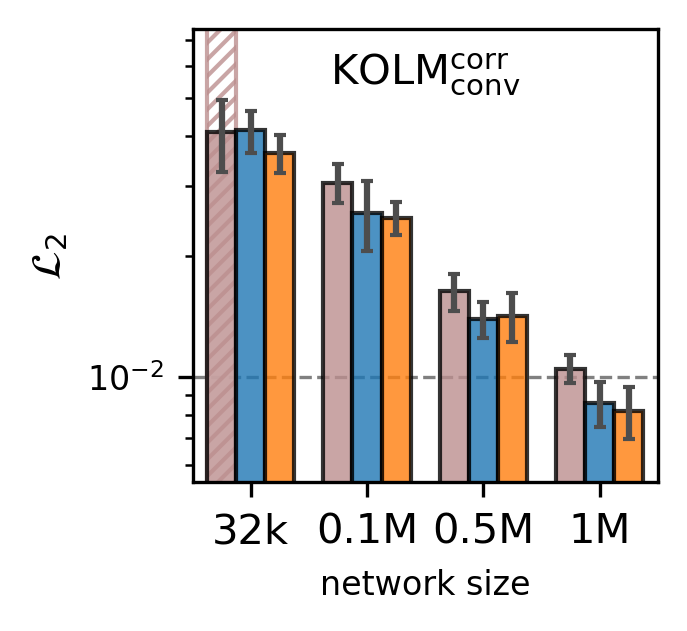

In [19]:
# MSE ERROR PLOT
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

bar_width = 1
bar_gap = 0.0
group_gap = 1
opacity = .8
capsize=1.5
edgecolor='black'
ecolor="0.3"
fig = plt.figure(figsize=(2, 2), dpi=300)
ax = fig.add_subplot()
k = 0
for i, xb in enumerate(block_groups):
    for j, x in enumerate(xb):
        if x in nan_idx:
            ax.bar(k * (bar_gap + bar_width) + i * group_gap, average_mse[x]+1, bar_width, alpha=opacity, hatch='//////', 
                  color='white', edgecolor=color_selector[x], label=None)
        ax.bar(k * (bar_gap + bar_width) + i * group_gap, average_mse[x], bar_width, yerr=std_mse[x], alpha=opacity, capsize=capsize,
               ecolor=ecolor, color=color_selector[x], edgecolor=edgecolor, label=legends[legend_selector[x]])
        k += 1
tick_positions = []
prev_tick = -bar_width / 2
for i in range(len(x_blocks)):
    tick_positions.append(prev_tick + ((len(block_groups[i])) * bar_width +
                                       (len(block_groups[i]) - 1) * bar_gap) / 2)
    prev_tick += group_gap + (len(block_groups[i])) * bar_width + bar_gap * (len(block_groups[i]))
ax.set_xticks(tick_positions)
ax.set_xticklabels(x_blocks)
ax.set_yscale('log')
ax.set_ylabel(r'$\mathcal{L}_2$')
ax.set_xlabel(r'network size', fontsize=8)
ax.set_ylim([None, average_mse[0]+std_mse[0]*4])
ax.set_xlim([-1, len(x_blocks)*4-1])
ax.set_title(r'$\mathrm{KOLM}^{\mathrm{corr}}_{\mathrm{conv}}$', y=1, pad=-13, fontsize=10)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.tick_params(axis='y', which='major', labelsize=8)
plt.show()

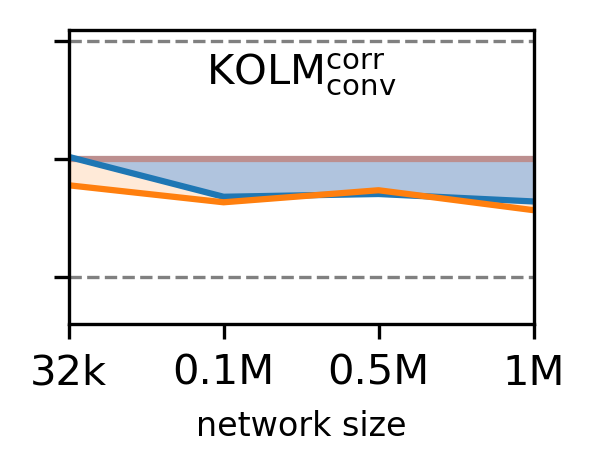

In [20]:
fig = plt.figure(figsize=(2, 1.3), dpi=300)
ax = fig.add_subplot()

index = np.arange(0,len(block_groups))
rects = ax.plot(index, np.array(average_mse)[np.array([b[0] for b in block_groups])]/np.array(average_mse)[np.array([b[0] for b in block_groups])],
                color='rosybrown', label='one step',)
rects = ax.plot(index, np.array(average_mse)[np.array([b[1] for b in block_groups])]/np.array(average_mse)[np.array([b[0] for b in block_groups])],
                color='tab:blue',label='no-grad',)
rects = ax.plot(index, np.array(average_mse)[np.array([b[2] for b in block_groups])]/np.array(average_mse)[np.array([b[0] for b in block_groups])],
                color='tab:orange',label='with-grad',)

ax.fill_between(index, np.array(average_mse)[np.array([b[2] for b in block_groups])]/np.array(average_mse)[np.array([b[0] for b in block_groups])],
                1, alpha=opacity*.2, color='tab:orange')

ax.fill_between(index, np.array(average_mse)[np.array([b[1] for b in block_groups])]/np.array(average_mse)[np.array([b[0] for b in block_groups])],
                1, alpha=1,color='lightsteelblue')#plot_settings['opacity']*.2, color='tab:blue')

ax.set_title(r'$\mathrm{KOLM}^{\mathrm{corr}}_{\mathrm{conv}}$', y=1, pad=-13, fontsize=10)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.set_xticks(index)
ax.set_xticklabels(x_blocks)
ax.set_yticklabels([])
ax.set_xlim([0, index[-1]])
ax.set_ylim([0.3, 1.55])
ax.set_xlabel(r'network size', fontsize=8)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.yaxis.grid(True,color='gray', linestyle='dashed')
ax.set_axisbelow(True)
plt.show()